# Conservative PINN (cPINN) for Discontinuous Solutions

### 1. Introduction: The Challenge of Discontinuous Solutions

Standard PINNs often struggle to approximate solutions that contain discontinuities, such as shock waves or sharp interfaces. This is because the global, continuous nature of a single neural network makes it difficult to capture abrupt changes.

The **Conservative Physics-Informed Neural Network (cPINN)** is a powerful technique designed to handle such problems. The core idea is based on **domain decomposition**:

1.  **Decompose:** The spatial-temporal domain is split into multiple smaller, non-overlapping subdomains. The discontinuities are expected to lie on the interfaces between these subdomains.
2.  **Separate Networks:** A separate PINN is assigned to each subdomain to learn the local, continuous part of the solution.
3.  **Conserve Flux:** A crucial "interface loss" term is added to the total loss function. This term enforces the conservation law (e.g., conservation of mass, momentum, or energy) across the interfaces, ensuring that the local solutions are physically connected in a conservative manner.

### 2. Simplified Demonstration: Inviscid Burgers' Equation

This notebook provides a **simplified, conceptual demonstration** of the domain decomposition idea using the inviscid Burgers' equation, which is known for developing shock waves.

-   **PDE:** $\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$, which can be written in conservative form as $\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\left(\frac{u^2}{2}\right) = 0$.
-   **Domain:** $x \in [-1, 1]$, $t \in [0, 1]$.
-   **Initial Condition:** $u(x, 0) = -\sin(\pi x)$.
-   **Boundary Conditions:** $u(-1, t) = u(1, t) = 0$.

**Important Note:** A full cPINN implementation requires a custom training loop to train multiple networks simultaneously and manage the complex interface losses. This is beyond the standard `dde.Model` API. This script simplifies the concept by:

1.  Decomposing the domain into two subdomains at the shock location ($x=0$).
2.  Training **two independent PINNs**, one for each subdomain.
3.  Stitching the results together for visualization.

This approach demonstrates domain decomposition but **omits the crucial flux conservation loss term**. Therefore, it's a conceptual illustration, not a true cPINN.



In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


### Step 1: Domain Decomposition and PDE Definition

First, we define the geometry. The key step is to split the spatial domain `x` in `[-1, 1]` into two subdomains at the expected shock location, `x=0`.

-   **Subdomain 1 (Left):** `x` in `[-1, 0]`
-   **Subdomain 2 (Right):** `x` in `[0, 1]`

We then define the PDE in its conservative (or flux) form. This form is essential for cPINNs because the interface conditions are based on conserving the flux `F(u)`. For the Burgers' equation, the flux is `F(u) = u^2 / 2`.



In [2]:
# --- 1. Domain Decomposition ---
# We split the domain x in [-1, 1] into two subdomains at x=0.
# Subdomain 1 (left): x in [-1, 0]
# Subdomain 2 (right): x in [0, 1]
geom1 = dde.geometry.Interval(-1, 0)
geom2 = dde.geometry.Interval(0, 1)

timedomain = dde.geometry.TimeDomain(0, 1)

geomtime1 = dde.geometry.GeometryXTime(geom1, timedomain)
geomtime2 = dde.geometry.GeometryXTime(geom2, timedomain)

# --- Define the PDE (Flux form) ---
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    # Flux F(u) = u^2 / 2
    F = u**2 / 2
    dF_x = dde.grad.jacobian(F, x, i=0, j=0)
    return du_t + dF_x

# --- Common Initial Condition ---
# This function will be used for both subdomains.
# We make it robust to handle both NumPy arrays (from dde.IC) and backend tensors.
def ic_func(x):
    if isinstance(x, np.ndarray):
        sin = np.sin
    else:
        sin = dde.backend.sin
    return -sin(np.pi * x[:, 0:1])



### Step 2: Create and Train Independent PINNs

Now, we create and train two separate PINN models, one for each subdomain. In this simplified setup, the interface at `x=0` is treated simply as another Dirichlet boundary condition for each model.

**Reminder:** A true cPINN would not do this. It would train both networks **simultaneously** with a shared loss function that includes:
-   `L_pde` from Subdomain 1
-   `L_pde` from Subdomain 2
-   `L_bc` for the external boundaries
-   `L_ic` for the initial condition
-   `L_interface` to enforce flux conservation between the two networks at `x=0`.

#### Model for Subdomain 1 (Left: `x` in `[-1, 0]`)

We define the Dirichlet boundary conditions at `x=-1` (external) and `x=0` (interface). For simplicity, we set `u(0, t) = 0`, although this is not physically accurate and is a major simplification compared to a real cPINN.


In [ ]:
print("--- Training Model for Subdomain 1 (x in [-1, 0]) ---")

# Define IC for the first subdomain
ic1 = dde.IC(geomtime1, ic_func, lambda _, on_initial: on_initial)

# Define BCs for the first subdomain
bc_left1 = dde.DirichletBC(geomtime1, lambda x: 0, lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], -1))
# Interface at x=0 is just another boundary for this simplified model
bc_right1 = dde.DirichletBC(geomtime1, lambda x: 0, lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 0))

# Set up the data object and network
data1 = dde.data.TimePDE(geomtime1, 
                         pde, 
                         [bc_left1, bc_right1, ic1], 
                         num_domain=1270, 
                         num_boundary=40, 
                         num_initial=80)

net1 = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model1 = dde.Model(data1, net1)

# Compile and train
model1.compile("adam", lr=1e-3)
model1.train(iterations=10000)


--- Training Model for Subdomain 1 (x in [-1, 0]) ---
Compiling model...
'compile' took 13.505799 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.99e-02, 2.70e-02, 3.62e-02, 5.25e-01]    [6.99e-02, 2.70e-02, 3.62e-02, 5.25e-01]    []  


c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [3.87e-02, 1.29e-03, 9.00e-03, 5.97e-02]    [3.87e-02, 1.29e-03, 9.00e-03, 5.97e-02]    []  
2000      [2.97e-02, 1.53e-05, 3.98e-03, 5.07e-02]    [2.97e-02, 1.53e-05, 3.98e-03, 5.07e-02]    []  
3000      [2.84e-02, 7.17e-06, 2.93e-03, 4.93e-02]    [2.84e-02, 7.17e-06, 2.93e-03, 4.93e-02]    []  
4000      [2.73e-02, 5.83e-06, 2.32e-03, 4.89e-02]    [2.73e-02, 5.83e-06, 2.32e-03, 4.89e-02]    []  
5000      [2.68e-02, 2.41e-06, 1.96e-03, 4.85e-02]    [2.68e-02, 2.41e-06, 1.96e-03, 4.85e-02]    []  
6000      [2.61e-02, 1.43e-06, 1.70e-03, 4.81e-02]    [2.61e-02, 1.43e-06, 1.70e-03, 4.81e-02]    []  
7000      [2.51e-02, 4.33e-06, 8.81e-04, 4.83e-02]    [2.51e-02, 4.33e-06, 8.81e-04, 4.83e-02]    []  
8000      [2.52e-02, 6.39e-06, 5.00e-04, 4.73e-02]    [2.52e-02, 6.39e-06, 5.00e-04, 4.73e-02]    []  
9000      [2.47e-02, 9.23e-07, 3.06e-04, 4.64e-02]    [2.47e-02, 9.23e-07, 3.06e-04, 4.64e-02]    []  
10000     [2.42e-02, 1.02e-06, 5.62e-05, 4.59e-02]    [2.42e-02, 1.02e-06

(<deepxde.model.LossHistory at 0x24660c33010>,
 <deepxde.model.TrainState at 0x24660efe2d0>)

#### Model for Subdomain 2 (Right: `x` in `[0, 1]`)

Similarly, we define the model for the right subdomain. We must redefine the initial condition (`IC`) for the new geometry `geomtime2`.



In [ ]:
print("\n--- Training Model for Subdomain 2 (x in [0, 1]) ---")

# Define IC for the second subdomain
ic2 = dde.IC(geomtime2, ic_func, lambda _, on_initial: on_initial)

# Define BCs for the second subdomain
# Interface at x=0
bc_left2 = dde.DirichletBC(geomtime2, lambda x: 0, lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 0))
bc_right2 = dde.DirichletBC(geomtime2, lambda x: 0, lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 1))

# Set up the data object and network
data2 = dde.data.TimePDE(geomtime2, 
                         pde, 
                         [bc_left2, bc_right2, ic2], 
                         num_domain=1270, 
                         num_boundary=40, 
                         num_initial=80)

net2 = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model2 = dde.Model(data2, net2)

# Compile and train
model2.compile("adam", lr=1e-3)
model2.train(iterations=10000)



--- Training Model for Subdomain 2 (x in [0, 1]) ---
Compiling model...
'compile' took 0.000086 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.36e-02, 3.36e-02, 1.28e-02, 5.10e-01]    [7.36e-02, 3.36e-02, 1.28e-02, 5.10e-01]    []  
1000      [3.90e-02, 9.41e-03, 1.46e-03, 5.95e-02]    [3.90e-02, 9.41e-03, 1.46e-03, 5.95e-02]    []  
2000      [2.94e-02, 4.17e-03, 5.64e-05, 4.94e-02]    [2.94e-02, 4.17e-03, 5.64e-05, 4.94e-02]    []  
3000      [2.78e-02, 3.32e-03, 1.37e-05, 4.89e-02]    [2.78e-02, 3.32e-03, 1.37e-05, 4.89e-02]    []  
4000      [2.67e-02, 2.33e-03, 1.38e-06, 4.89e-02]    [2.67e-02, 2.33e-03, 1.38e-06, 4.89e-02]    []  
5000      [2.64e-02, 1.75e-03, 3.60e-06, 4.86e-02]    [2.64e-02, 1.75e-03, 3.60e-06, 4.86e-02]    []  
6000      [2.62e-02, 1.27e-03, 2.99e-06, 4.83e-02]    [2.62e-02, 1.27e-03, 2.99e-06, 4.83e-02]    []  
7000      [2.52e-02, 7.14e-04, 2.23e-06, 4.75e-02]

(<deepxde.model.LossHistory at 0x2468053af90>,
 <deepxde.model.TrainState at 0x2468052d690>)

### Step 3: Stitch and Visualize the Solution

After training the two independent models, we can visualize the overall solution. To do this, we:

1.  Create a uniform grid of test points covering the entire domain `(x, t)`.
2.  Split these test points into two groups: those in the left subdomain (`x <= 0`) and those in the right subdomain (`x > 0`).
3.  Use `model1` to predict the solution for the left points and `model2` for the right points.
4.  Combine, or "stitch," these predictions into a single solution field.

We will then create two plots:
-   A 2D color map to show the evolution of the solution over time, where the shock formation should be visible.
-   Several 1D snapshots at different time steps to clearly see the profile of the wave as it steepens and forms a shock.



In [7]:
# 1. Create a grid of test points
x = np.linspace(-1, 1, 201)
t = np.linspace(0, 1, 101)
X, T = np.meshgrid(x, t)
xt_test = np.vstack((X.flatten(), T.flatten())).T

# 2. Predict on each subdomain and combine
x_left_mask = xt_test[:, 0] <= 0
x_right_mask = xt_test[:, 0] > 0

# 3. Stitch the predictions
u_pred = np.zeros(len(xt_test))
u_pred[x_left_mask] = model1.predict(xt_test[x_left_mask])[:, 0]
u_pred[x_right_mask] = model2.predict(xt_test[x_right_mask])[:, 0]
U_pred = u_pred.reshape(X.shape)




--- Visualizing Combined Solution ---


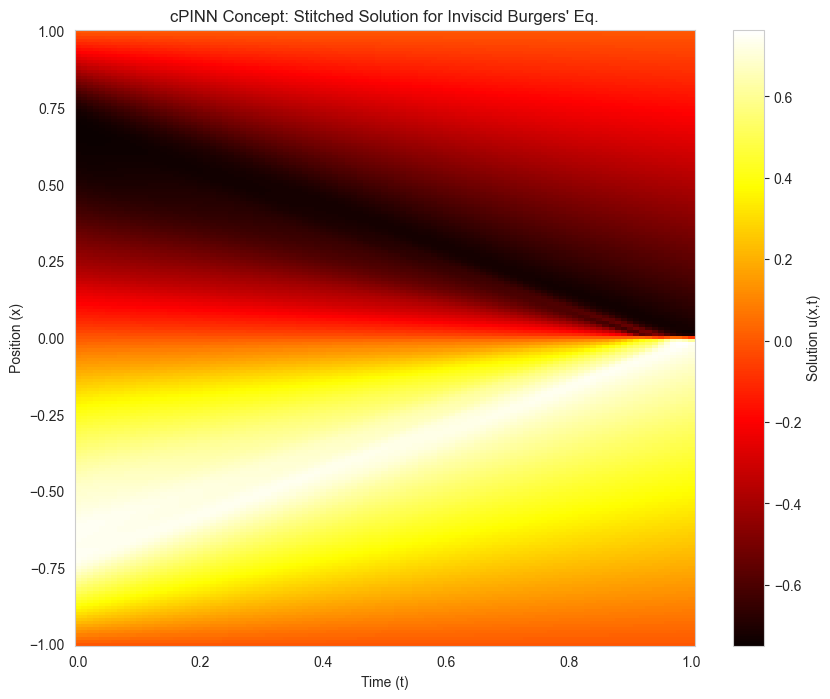

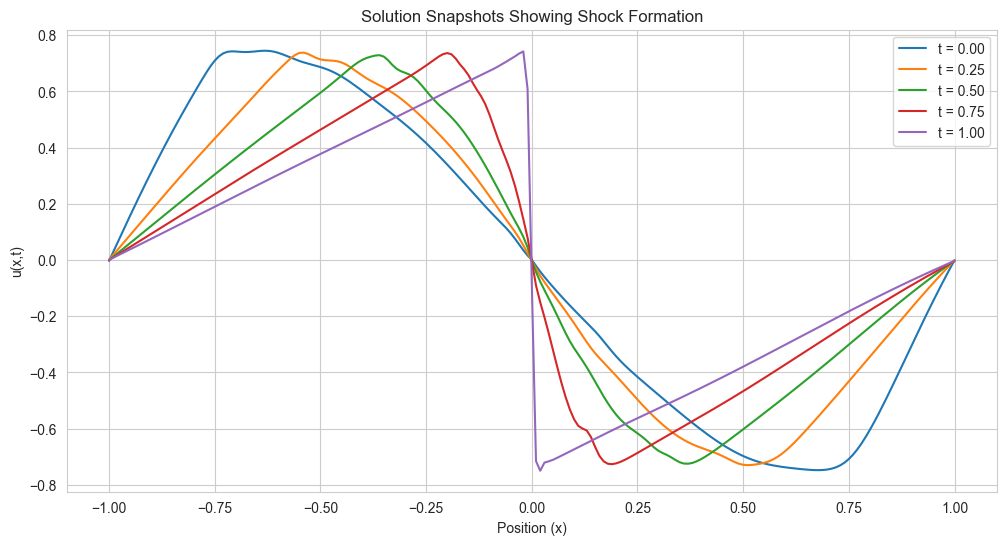

In [8]:
print("\n--- Visualizing Combined Solution ---")

# 4. Plotting the 2D solution
plt.figure(figsize=(10, 8))
# Note: DeepXDE's TimePDE convention is (x,t) but meshgrid default is (row, col) -> (y,x)
# So we plot T (time) on the x-axis and X (space) on the y-axis.
plt.pcolormesh(T, X, U_pred, shading='auto', cmap='hot')
plt.colorbar(label="Solution u(x,t)")
plt.xlabel("Time (t)")
plt.ylabel("Position (x)")
plt.title("cPINN Concept: Stitched Solution for Inviscid Burgers' Eq.")
plt.show()

# # 5. Plotting 1D snapshots
# plt.figure(figsize=(12, 6))
# time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
# for t_val in time_snapshots:
#     # Find the column index closest to the desired time
#     t_index = np.argmin(np.abs(t - t_val))
#     # U_pred is indexed (space, time) because of how meshgrid was reshaped
#     plt.plot(x, U_pred[:, t_index], label=f't = {t_val:.2f}')

# plt.title("Solution Snapshots Showing Shock Formation")
# plt.xlabel("Position (x)")
# plt.ylabel("u(x,t)")
# plt.legend()
# plt.grid(True)
# plt.show()



# 5. Plotting 1D snapshots (Corrected version)
plt.figure(figsize=(12, 6))
time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
for t_val in time_snapshots:
    # Find the column index closest to the desired time
    t_index = np.argmin(np.abs(t - t_val))
    # U_pred is (time_steps, x_steps) = (101, 201) because of reshape(X.shape)
    # So we need to use U_pred[t_index, :] to get the spatial profile at time t_index
    plt.plot(x, U_pred[t_index, :], label=f't = {t_val:.2f}')

plt.title("Solution Snapshots Showing Shock Formation")
plt.xlabel("Position (x)")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.show()
